# Optimization method to simulate the dispatch of EV aggegator

This code can be used to model some EV that will need to be charge.
The problem is formulated as an optimization problem. Goal is to maximize the value of the system.
One big assumption is that EV and charging points are bi-directional

In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_csv('bourseEpex_06_06_2024.csv')
print(len(df))
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'bourseEpex_06_06_2024.csv'

In [ ]:
class EV_BATTERY:
    
    def __init__(self, P_charg: float,
                capacity: float,
                P_dischar: float,
                eta : float,
                n_EV : int) -> None:
        """
        Initialize the battery
        Args :

        P_charg (float) : max power to charge
        capacity (float) : battery storage capacity
        P_dischar (float) : discharge capacity
        """
        np.random.seed(0)
        self.P_charg = P_charg
        self.capacity = capacity
        self.P_dischar = P_dischar
        self.eta = eta
        self.n_EV = n_EV


    def read_spot_price(self, path_to_price : str, 
                        resample = False):
        """
        Read the df of price
        """
        df_price = pd.read_csv(path_to_price)

        self.price_ls = df_price['Prix (€/MWh)']
        self.delta_T =1
        if resample :
            self.delta_T = 1/6
            resampled_list = []
            for elem in self.price_ls:
                resampled_list.extend([elem] * 6)
            self.price_ls = resampled_list

        self.T = len(self.price_ls)



    def generate_contiguous_list(self):
        """
        Generates a list with contiguous blocks of 1s and 0s where the series of 1s starts at a random position and has a random length.
        
        Parameters:
        length (int): Length of the list.
        
        Returns:
        list: The generated list.
        """
        length = self.T
        if length <= 1:
            raise ValueError("Length of the list must be greater than 1.")
        
        # Determine the length of the series of 1s
        len_ones = random.randint(1, length - 1)
        
        # Determine the starting position for the series of 1s
        start_pos = random.randint(0, length - len_ones)
        
        # Generate the list with contiguous blocks of 1s and 0s
        ls = [0] * length
        for i in range(len_ones):
            ls[start_pos + i] = 1
        
        return ls

    def generate_contiguous_matrix(self):
        """
        Generates a matrix with contiguous blocks of 1s and 0s in each column.
        
        Parameters:
        rows (int): Number of rows in the matrix.
        cols (int): Number of columns in the matrix.
        
        Returns:
        np.ndarray: The generated matrix.
        """
        rows = self.T
        cols = self.n_EV
        matrix = np.zeros((rows, cols), dtype=int)
        
        for col in range(cols):
            matrix[:, col] = self.generate_contiguous_list()
        
        self.schedule_matrix = matrix

        self.SOC_ini = np.random.uniform(low=0.0, high=1.0, size= (self.n_EV,))


    def battery_dispatch(self,
                         charging_type:str = 'VPP'):
        """
        Optimize the battery dispatch using the price collected
        from RTE

        Args:
        charging_type (str) : smart, VPP, fast 
        """
        #Time over which to dispatch
        T = len(self.price_ls)

        # Model declaration
        model = Model("battery")


        # Decision variables
        x_ch = model.addVars(T,self.n_EV, lb=0.0, vtype=GRB.CONTINUOUS, name="Charge") # Charge from the battery 
        x_dch = model.addVars(T,self.n_EV, lb=0.0, vtype=GRB.CONTINUOUS, name="Discharge") # Discharge from the battery
        x_soc = model.addVars(T, self.n_EV, lb=0.0, ub = 1, vtype=GRB.CONTINUOUS, name="SOC") # State of charge of battery
        x_dispatch = model.addVars(T, self.n_EV, vtype=GRB.BINARY, name="dispatch") # Decision on dispatch (0 => no dispatch, 1 => dispatch)
        

        # Objective function: Maximize the revenue of the battery
        if charging_type == 'VPP':
            model.setObjective(quicksum(quicksum((x_dch[i,k]*self.eta - x_ch[i,k])*self.price_ls[i]*self.delta_T*10**-3
                                                for i in range(T)) 
                                                for k in range(self.n_EV)), GRB.MAXIMIZE)
        elif charging_type == 'smart':
            model.setObjective(quicksum(quicksum((x_ch[i,k])*self.price_ls[i]*self.delta_T*10**-3
                                    for i in range(T)) 
                                    for k in range(self.n_EV)), GRB.MINIMIZE)

        elif charging_type == 'fast':
            model.setObjective(quicksum(quicksum(((x_soc[i,k]))
                                    for i in range(T)) 
                                    for k in range(self.n_EV)), GRB.MAXIMIZE)


        # Constraints (1)
        # Cannot discharge more than the available energy
        for t in range(T):
            for k in range(self.n_EV):
                model.addConstr(x_dch[t,k] <= x_dispatch[t,k]*x_soc[t,k]*self.capacity * self.schedule_matrix[t,k]/self.delta_T)
                model.addConstr(x_dch[t,k] <= x_dispatch[t,k]*self.P_dischar * self.schedule_matrix[t,k])
        

        # Constraints (2)
        # Cannot charge more than available and cannot charge while dispatching
        for t in range(T): 
            for k in range(self.n_EV):
                model.addConstr(x_ch[t,k] <= (1-x_dispatch[t,k])*(1-x_soc[t,k])*self.capacity * self.schedule_matrix[t,k]/self.delta_T)
                model.addConstr(x_ch[t,k] <= (1-x_dispatch[t,k])*self.P_charg * self.schedule_matrix[t,k])



        # Constraint (4)
        # Create the state of charge variable (start with full)
        # Start with a charged battery
        for k in range(self.n_EV):
            model.addConstr(x_soc[0,k] == self.SOC_ini[k])
            if np.sum(self.schedule_matrix[:,k])>5:
                model.addConstr(x_soc[T-1,k] >= 1)
        
        # State of charge at each time step
        for t in range(1, T):
            for k in range(self.n_EV):
                model.addConstr((x_soc[t,k] - x_soc[t-1,k])*self.capacity == (x_ch[t-1,k] - x_dch[t-1,k])*self.delta_T)


        #Solve the model
        model.optimize()

        # Electrolizer state
        charge = np.zeros((T,self.n_EV))
        
        #Power of each electrolizer
        discharge = np.zeros((T,self.n_EV))
        SOC = np.zeros((T,self.n_EV))

        # Save the variables
        for j in range(T):
            for k in range(self.n_EV):
                charge[j,k] = x_ch[j,k].X
                discharge[j,k] = x_dch[j,k].X
                SOC[j,k] = x_soc[j,k].X

        if charging_type in ['VPP', 'smart']:
            obj = model.getObjective()
            self.obj_value = obj.getValue()
            print(f'Objective value for {charging_type} = {self.obj_value}')
        else : 
            self.obj_value = 0
            for k in range(self.n_EV):
                self.obj_value += np.sum(charge[:,k]*self.price_ls[:]*self.delta_T*10**-3)
            print(f'Objective value for {charging_type} = {self.obj_value}')

        return charge, discharge, SOC

In [ ]:
Batt = EV_BATTERY(P_charg=46, capacity=62, P_dischar=7, eta = 0.8, n_EV=250)

Batt.read_spot_price('bourseEpex_06_06_2024.csv', resample=True)
matrix = Batt.generate_contiguous_matrix()

print(matrix)

total_price = []

charge, discharge, SOC = Batt.battery_dispatch('VPP')
total_price.append(Batt.obj_value)

charge_smart, discharge_smart, SOC_smart = Batt.battery_dispatch('smart')
total_price.append(Batt.obj_value)

charge_fast, discharge_fast, SOC_fast = Batt.battery_dispatch('fast')
total_price.append(Batt.obj_value)


None
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 108244 rows, 144000 columns and 253664 nonzeros
Model fingerprint: 0xa6964602
Model has 72000 quadratic constraints
Variable types: 108000 continuous, 36000 integer (36000 binary)
Coefficient statistics:
  Matrix range     [2e-01, 6e+01]
  QMatrix range    [4e+02, 4e+02]
  QLMatrix range   [1e+00, 4e+02]
  Objective range  [2e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 5e+01]
  QRHS range       [4e+02, 4e+02]
Presolve removed 107693 rows and 143442 columns
Presolve time: 1.06s
Presolved: 947 rows, 690 columns, 2182 nonzeros
Variable types: 549 continuous, 141 integer (141 binary)
Found heuristic solution: objective 10.7085835

Root relaxation: objective 1.144804e+01, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

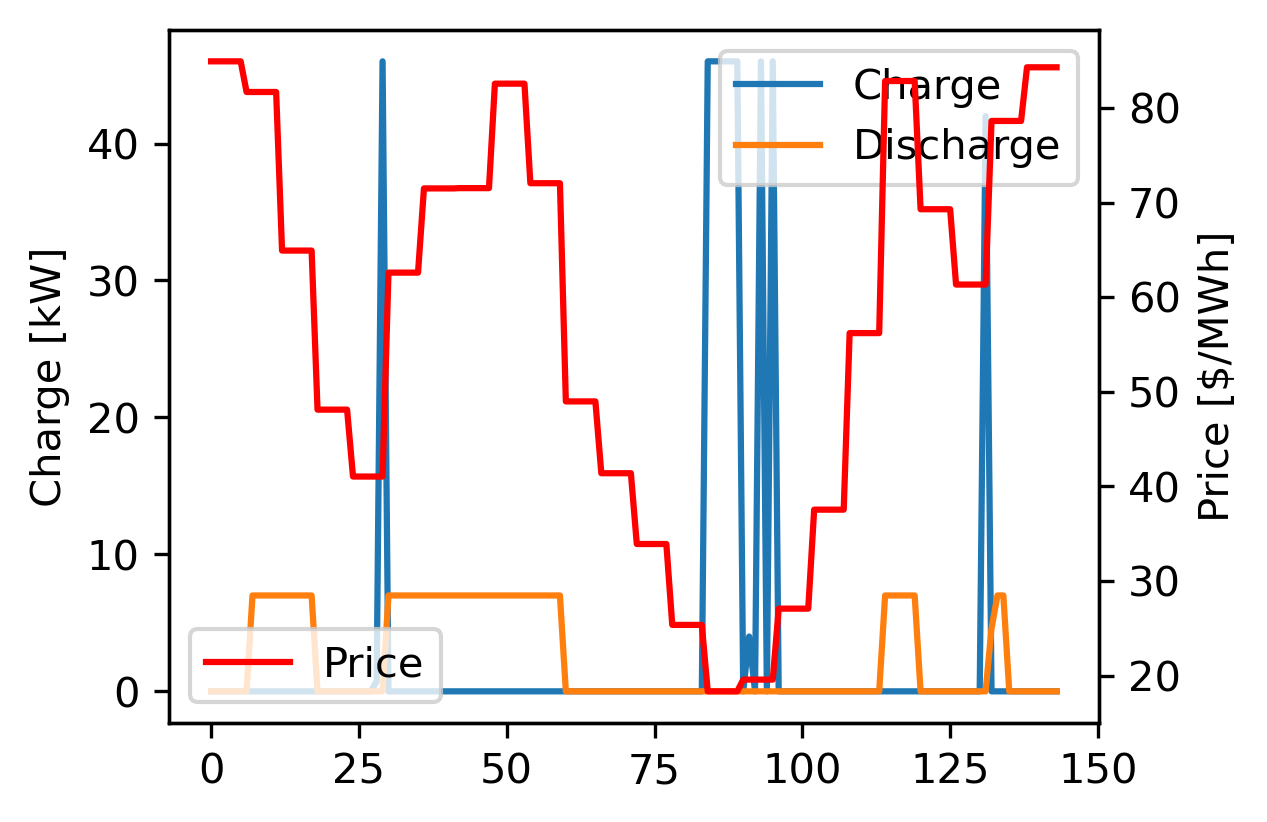

In [ ]:
fig, ax = plt.subplots(figsize = (4,3), dpi = 300)

ls_time = [i for i in range(len(Batt.price_ls))]
ax2 = ax.twinx()

ax.plot(ls_time, charge[:,5], label = 'Charge')
ax.plot(ls_time, discharge[:,5], label = 'Discharge')
ax2.plot(ls_time, Batt.price_ls, label = 'Price', color = 'red')

ax2.set_ylabel('Price [$/MWh]')
ax.set_ylabel('Charge [kW]')
ax.legend(loc = 'upper right')
ax2.legend(loc = 'lower left')

In [ ]:
fig, ax = plt.subplots(figsize = (5,3), dpi = 300)


ax2 = ax.twinx()
ax2.plot(ls_time, SOC[:,6], label = 'VPP', color ='red')
ax2.plot(ls_time, SOC_smart[:,6], label = 'Smart', color ='green')
ax2.plot(ls_time, SOC_fast[:,6], label = 'Fast', color ='orange')
ax.plot(ls_time, Batt.price_ls, label = 'Price', linestyle='--')
ax.legend()
ax.set_ylabel('Price [$/MWh]')
ax2.set_ylabel('State of charge')
ax2.legend(loc = 'lower right')

NameError: name 'plt' is not defined

11.45
198.26
487.3


Text(0, 0.5, 'Price [$]')

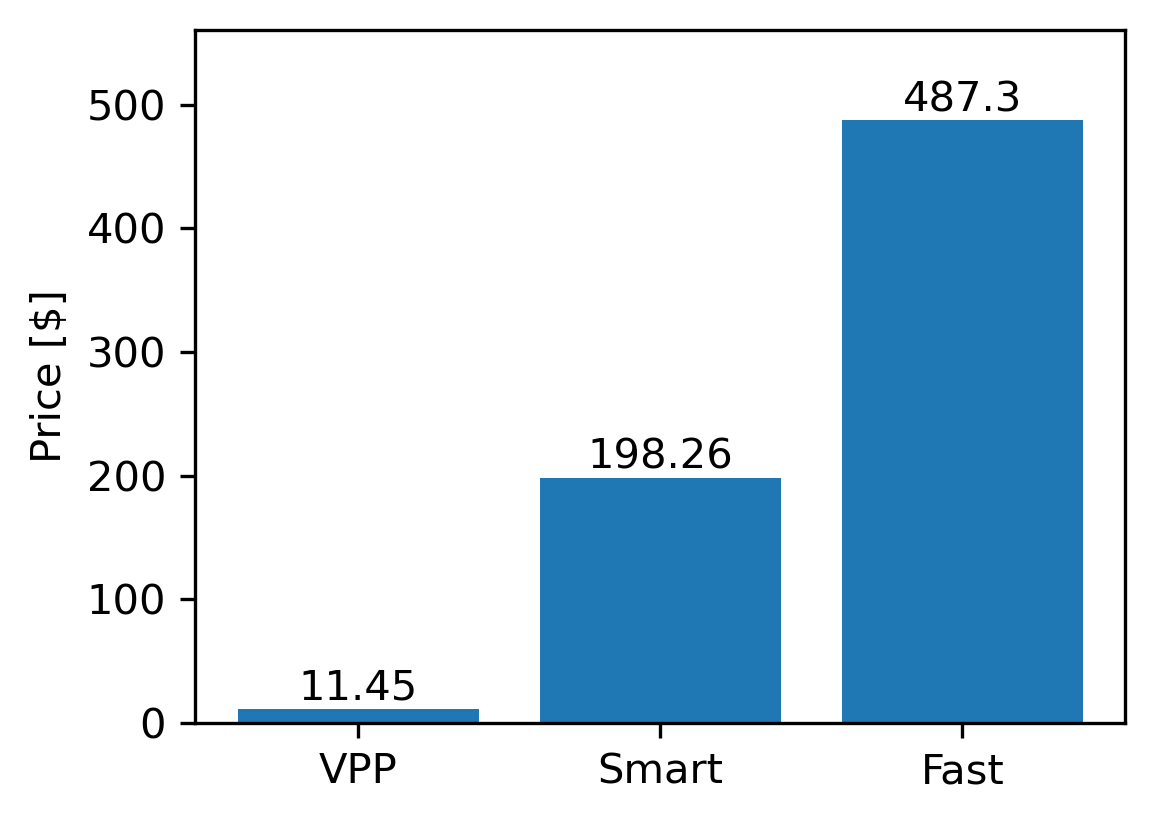

In [ ]:
fig, ax = plt.subplots(figsize = (4,3), dpi = 300)


bars = ax.bar(['VPP', 'Smart', 'Fast'], total_price)

ax.set_ylim(0, np.max(total_price)*1.15)
# Adding annotations
for bar, value in zip(bars, total_price):
    height = np.round(bar.get_height(),2)
    print(height)
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{np.round(value,2)}', ha='center', va='bottom')

ax.set_ylabel('Price [$]')


In [ ]:
print(discharge)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [0.         0.         0.         7.         0.        ]
 [7.         0.         0.         7.         0.        ]
 [7.         0.         0.         7.         0.        ]
 [7.         0.         0.         7.         0.        ]
 [7.         0

In [ ]:
print(np.round(SOC,2))

[[0.24 0.53 0.6  0.35 0.05]
 [0.24 0.51 0.6  0.35 0.05]
 [0.24 0.5  0.6  0.35 0.05]
 [0.24 0.48 0.6  0.35 0.05]
 [0.24 0.46 0.6  0.35 0.05]
 [0.24 0.44 0.6  0.35 0.05]
 [0.24 0.42 0.6  0.35 0.05]
 [0.24 0.4  0.6  0.35 0.05]
 [0.24 0.38 0.6  0.35 0.05]
 [0.24 0.36 0.6  0.35 0.05]
 [0.24 0.35 0.6  0.35 0.05]
 [0.24 0.33 0.6  0.35 0.05]
 [0.24 0.31 0.6  0.35 0.05]
 [0.24 0.29 0.6  0.35 0.05]
 [0.24 0.27 0.6  0.35 0.05]
 [0.24 0.25 0.6  0.35 0.05]
 [0.24 0.23 0.6  0.35 0.05]
 [0.24 0.21 0.6  0.35 0.05]
 [0.24 0.19 0.6  0.35 0.05]
 [0.24 0.18 0.6  0.35 0.05]
 [0.24 0.16 0.6  0.35 0.05]
 [0.24 0.14 0.6  0.35 0.05]
 [0.24 0.12 0.6  0.35 0.05]
 [0.24 0.1  0.6  0.35 0.05]
 [0.24 0.08 0.6  0.35 0.05]
 [0.24 0.21 0.6  0.35 0.05]
 [0.24 0.33 0.6  0.35 0.05]
 [0.24 0.45 0.6  0.35 0.05]
 [0.24 0.58 0.6  0.35 0.05]
 [0.24 0.7  0.67 0.35 0.05]
 [0.24 0.82 0.79 0.35 0.05]
 [0.24 0.8  0.77 0.35 0.05]
 [0.24 0.79 0.75 0.35 0.05]
 [0.24 0.77 0.73 0.35 0.05]
 [0.24 0.75 0.72 0.35 0.05]
 [0.24 0.73 0.7  0.3

In [ ]:
print(charge)

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.  

In [ ]:
print(Batt.schedule_matrix)

[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [1 1 1 1 0]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [1 1 0 1 1]
 [1 1 0 1 1]
 [1 1 0 1 1]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


In [ ]:
print(8/62*100)

12.903225806451612
